## Load things

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')


from ipywidgets import interact
import os,sys
# sys.addaudithook
rpath = os.getcwd()
sys.path.insert(0,"../")
# import utils

import dimred ### library of dimension reduction

In [2]:
import ipywidgets
from ipywidgets import interact

from dimred.data.loader import LoadOne
from dimred.data.preprocess import MinMaxScalar,ZeroMeanScalar,MeanMaxScalar,AvgMaxScalar
# dimred.
from dimred.data.preprocess import scale_sanity,Scalar

from dimred.models.linear.transform import Kurtosis
from dimred.models.linear.transform import co_variance,co_kurtosis
from dimred.tester.plotting import plot_embedding,plot_compare
from dimred.tester.metrics import mean_sq_error,mean_abs_error


## Read data

In [3]:
loader = LoadOne()

In [8]:
# domains = (1,4)

# xrig = loader.getDomain(domains)
# loader.plotImg(spec=12)

reading file autoignition.1.0000E-05.field.mpi...


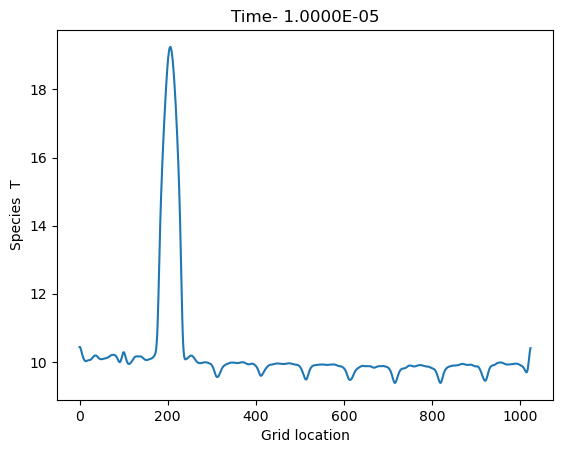

In [4]:
time_step = 100

xrig = loader.getTime(time_step,verbose=3)[:,:14]
loader.plotLine(spec=12,time=time_step)

## Dim reduction

 Transformation

- xreduced is 4D vector:
- project back to original space
- Low rank newly reconstructed matrix

In [5]:
def reshape_step(xinput):
    nvs = xinput.shape[-1]  ## reshapeing to oned array for cantera
    xinp = xinput.reshape(-1,nvs)
    return xinp

In [13]:
def transform_step(xinput,retain=4,plots=True,verbose=2,moment=co_kurtosis,scalar=AvgMaxScalar):
    xrig = reshape_step(xinput).copy()    
    ## Reading and scaling data:-->
    xold = xrig.copy()
    if verbose>0:
        print("Orignial data")
        scale_sanity(xrig)
    slr = Scalar(scalar)
    slr.fit(xrig)
    xscaled = slr.transform(xrig) #scale_sanity(xscaled)
    
    ## Moment calculation: -->
    clf = Kurtosis(n_retain=retain)
    clf.fit(xscaled,moment=moment)  ## or co_variance; user inputx
    xred = clf.transform(xscaled)
    if plots:
        plot_embedding(xred,titler=f"{moment.name}_space",color_spec=xscaled[:,10],cmap="jet")
    
    ## linear reconstruction:-->
    xpew = clf.transform2(xred)
    ## xred is x reduced| et voila
    xnew = slr.transform2(xpew)
    err = mean_sq_error(xnew,xold)
    
    ## plotting and results: -->
#     if plots:
#         plot_compare(xold,xnew)
    
    if verbose>1:
        print("Reconstructed data")
        scale_sanity(xnew)
    
    print(f"Error in reconstruction after retaining {retain} vectors is {err:.4f}")
    return clf,xold,xnew

Xnew is transformed data

Xold is original data

## Source Term comparison 

In [7]:
import cantera as ct
syngas = ct.Solution('cantera-module/COH2.cti')

indices = {'temp':12,'press':13}
references = {'press':1.41837E+05,'temp':120} ## same keys


In [44]:
# MFID is Mass fraction index in data; Samul L Jacksons MF
# NVR is Num of variables to retain; ignore velocity components

In [8]:
def cantera_step(xinput,NVR=14,MFID=12,indices=indices,references=references,gas=syngas,verbose=2):
    
    xinp = reshape_step(xinput).copy()       
    nx,nvs = xinp.shape
    xinp = xinp[:,:NVR]

    ref_array = np.ones(NVR) #reference values required for conversion into the SI units
    for k,v in indices.items():
        ref_array[v] = references[k]

    if verbose:   ## print gas properties
        print(gas())

    ## below are hardcoded numbers --- TBD

    prod_rates = []
    react_rates = []
    for i in range(nx):                                  #iterating over all grid points
    #     print(i)                                            
        sample = xinp[i]*ref_array                 #converting into the SI units
        gas.Y = sample[:MFID]                                #setting up the mass fraction of the species
        gas.TP = sample[MFID:NVR]                             #setting up the temperature and pressure of gas
        prod_rates.append(gas.net_production_rates)      #calculating production/consumption rates
        react_rates.append(gas.net_rates_of_progress)    #calculating reaction rates
    return np.array(prod_rates),np.array(react_rates)

## Final calculation

reading file autoignition.1.0000E-05.field.mpi...
Orignial data
Maxima is 19.25 
 Minima is 0.00 
 (1024, 14)
Reconstructed data
Maxima is 18.32 
 Minima is -0.02 
 (1024, 14)
Error in reconstruction after retaining 4 vectors is 0.0045


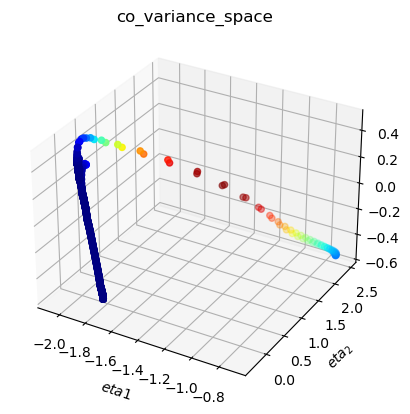

In [14]:
time_step = 100
xrig = loader.getTime(time_step,verbose=-1)[:,:14]


samul = {'covaiance':co_variance,'cokurtosis':co_kurtosis}

# loader.plotLine(spec=12,time=time_step)
cmv,xold,xnew = transform_step(xrig,moment=co_variance)
prod_new,react_new = cantera_step(xnew,verbose=0) 
prod_old,react_old = cantera_step(xold,verbose=0)

Orignial data
Maxima is 19.25 
 Minima is 0.00 
 (1024, 14)
Reconstructed data
Maxima is 18.59 
 Minima is -0.02 
 (1024, 14)
Error in reconstruction after retaining 4 vectors is 0.0038


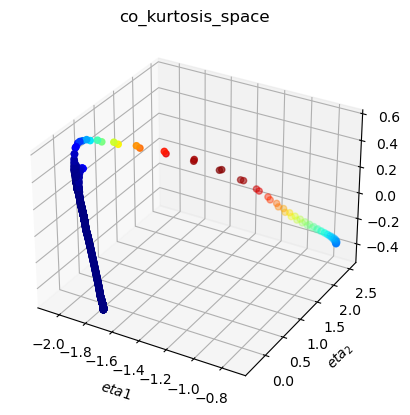

In [15]:
cmk,kold,knew = transform_step(xrig,moment=co_kurtosis)
kprod_new,kreact_new = cantera_step(knew,verbose=0) 
kprod_old,kreact_old = cantera_step(kold,verbose=0)

In [16]:
def plotSpectra(s1,s2,u1,u2):
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
    ax1.plot(np.log(s1),'--ob',label='covariance')
    ax1.plot(np.log(s2),'--or',label='cokurtosis')
    ax1.set_ylabel('singular value')
    ax1.legend()
    dots = [abs(v1@v2) for v1,v2 in zip(u1,u2)]
    ax2.plot(dots,'--og')
    ax2.set_ylabel('dot product')
    ax2.set_ylim(0,1.5)

    plt.show()
 



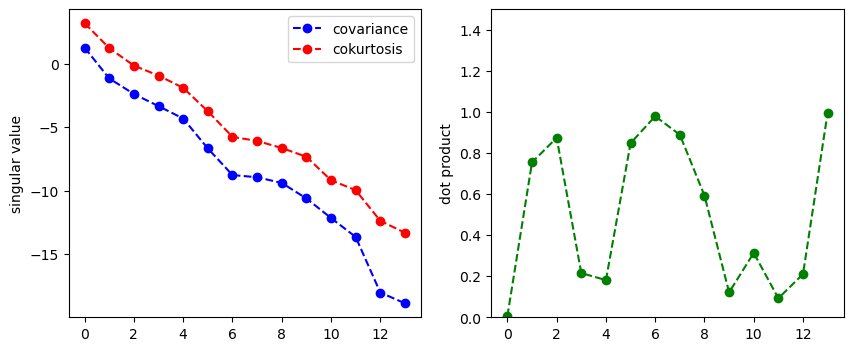

In [17]:
plotSpectra(cmv.s,cmk.s,cmv.u,cmk.u)

In [21]:
total = {}
olds={'production':prod_old,'reaction':react_old,'mass':xold}
news={'production':prod_new,'reaction':react_new,'mass':xnew}

total['covariance'] = {'old':olds,'new':news}

olds={'production':kprod_old,'reaction':kreact_old,'mass':kold}
news={'production':kprod_new,'reaction':kreact_new,'mass':knew}
total['cokurtosis'] = {'old':olds,'new':news}



## Interactive!

## Interactive!

## Interactive!

In [24]:
def f(moment,source,specs=0):
    plot_compare(total[moment]['old'][source],
                 total[moment]['new'][source],species=specs)

interact(f,moment=total.keys(),source=olds.keys(),specs=range(12))

interactive(children=(Dropdown(description='moment', options=('covariance', 'cokurtosis'), value='covariance')…

<function __main__.f(moment, source, specs=0)>

In [24]:
def f(moment,source,specs=0):
    plot_compare(total[moment]['old'][source],
                 total[moment]['new'][source],species=specs)

interact(f,moment=total.keys(),source=olds.keys(),specs=range(12))

interactive(children=(Dropdown(description='moment', options=('covariance', 'cokurtosis'), value='covariance')…

<function __main__.f(moment, source, specs=0)>